# Notebook \#3 - Laplace Neural Operator

In [ ]:
from utils.data import MultiFunctionDatasetODE, custom_collate_ODE_fn_fno 
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from models.model_lno import *
from utils.scripts import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
n_functions = 1000000
grf_lb = 0.02
grf_ub = 0.5
end_time = 1.0
num_domain = 200
num_initial = 20
batch_size = 1024
m = 200

dataset = MultiFunctionDatasetODE(
    m=m,
    n_functions=n_functions,
    function_types=['grf', 'linear', 'sine', 'polynomial','constant'],
    end_time = end_time,
    num_domain = num_domain,
    num_initial = num_initial,
    grf_lb = grf_lb,
    grf_ub = grf_ub
)

dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=custom_collate_ODE_fn_fno, shuffle=True)

In [ ]:
step_size = 100
gamma = 0.9
learning_rate = 0.001

modes = 32
width = 4
model = LNO1d(width, modes).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

epochs = 100
trained_model = train_lno(model, dataloader, optimizer, scheduler, device, epochs)

In [ ]:
modes = 16
width = 8

trained_model = LNO1d(width, modes)
trained_model.to(device)
trained_model.load_state_dict(torch.load('trained_models/lno/width-[8]-modes[16]/epochs_[50]_model_time_[20250423-174005]_loss_[0.0027].pth'))
trained_model.eval()  #

LNO1d(
  (fc0): Linear(in_features=2, out_features=8, bias=True)
  (conv0): PR()
  (w0): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [12]:
m = 200 
end_time = 1
epochs = 1500
learning_rate = 0.001

u_opt, x_opt, t = optimize_neural_operator(trained_model, objective_function, m, end_time, epochs, learning_rate)

Epoch [100/1500], Loss: 0.4281, time: 20:04:44.521790
Epoch [200/1500], Loss: 0.4062, time: 20:04:44.820932
Epoch [300/1500], Loss: 0.3933, time: 20:04:45.119135
Epoch [400/1500], Loss: 0.3853, time: 20:04:45.420088
Epoch [500/1500], Loss: 0.3803, time: 20:04:45.717832
Epoch [600/1500], Loss: 0.3771, time: 20:04:46.015023
Epoch [700/1500], Loss: 0.3751, time: 20:04:46.312930
Epoch [800/1500], Loss: 0.3739, time: 20:04:46.610723
Epoch [900/1500], Loss: 0.3731, time: 20:04:46.908162
Epoch [1000/1500], Loss: 0.3727, time: 20:04:47.206453
Epoch [1100/1500], Loss: 0.3724, time: 20:04:47.504099
Epoch [1200/1500], Loss: 0.3723, time: 20:04:47.801391
Epoch [1300/1500], Loss: 0.3722, time: 20:04:48.098479
Epoch [1400/1500], Loss: 0.3722, time: 20:04:48.396711
Epoch [1500/1500], Loss: 0.3721, time: 20:04:48.699146


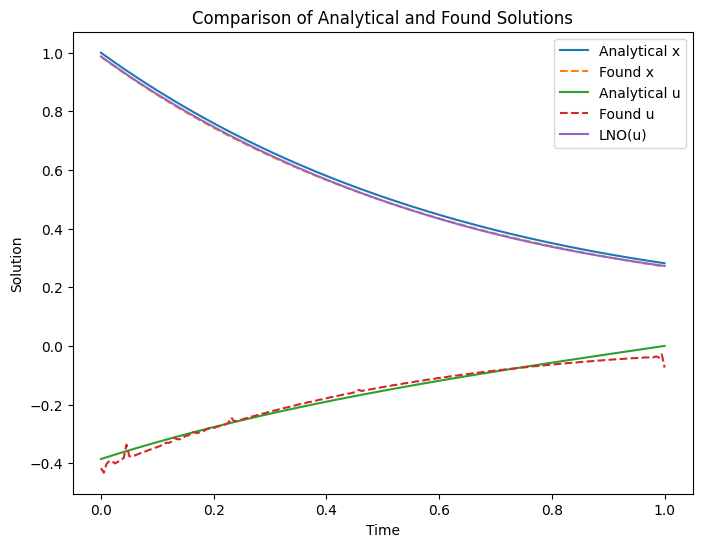

In [15]:
def analytical_x(t):
    numerator = np.sqrt(2) * np.cosh(np.sqrt(2) * (t - 1)) - np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

def analytical_u(t):
    numerator = np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

t_plot = np.linspace(0, end_time, m)

analytical_x_vals = analytical_x(t_plot)
analytical_u_vals = analytical_u(t_plot)

x_found = x_opt.cpu().detach().numpy()
u_found = u_opt.cpu().detach().numpy()
u_tensor = torch.from_numpy(analytical_u_vals).float().unsqueeze(0).to(device)

# Plot the results.
plt.figure(figsize=(8, 6))
plt.plot(t_plot, analytical_x_vals, label="Analytical x")
plt.plot(t_plot, x_found.reshape(200), label="Found x", linestyle='--')
plt.plot(t_plot, analytical_u_vals, label="Analytical u")
plt.plot(t_plot, u_found.reshape(200), label="Found u", linestyle='--')
plt.plot(t_plot, trained_model(u_tensor.unsqueeze(-1), torch.linspace(0, end_time, m).to(device) ).reshape(200).cpu().detach().numpy(), label="LNO(u)")
plt.xlabel("Time")
plt.ylabel("Solution")
plt.legend()
plt.title("Comparison of Analytical and Found Solutions")
plt.show()
